<a href="https://colab.research.google.com/github/HKLeeeee/AI_proj_Team2/blob/main/Hyper_parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

In [34]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product

In [3]:
from tensorflow.keras.applications import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Functions

In [9]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label-{}.csv'.format(int(case_name[-2:])))
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [5]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [6]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [7]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

# Load Data Set

In [10]:
IMAGE_SIZE = 480
BATCH_SIZE = 8

all_img_path, all_label = get_train_data('/content/drive/MyDrive/AI_proj/data/train')
test_img_path = get_test_data('/content/drive/MyDrive/AI_proj/data/test')

In [11]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [12]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

In [13]:
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [14]:
valid_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

# Definitions

In [21]:
def bulid_model(hyper_params : tuple) :
  pretrain_net, learning_rate, opti, loss, dropout = hyper_params

  base_model = None
  if pretrain_net == 'resnet50' :
    MODEL_IMAGE_SIZE = 224
    base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
    )
  elif pretrain_net == 'inception_v2_resnet':
    MODEL_IMAGE_SIZE = 299
    base_model = inception_resnet_v2.InceptionResNetV2(
        weights='imagenet',
        include_top = False,
        input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
    )
  elif pretrain_net == 'efficientnet_b4' :
    MODEL_IMAGE_SIZE = 380
    base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
    )
  base_model.trainable=False

  input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
  x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
  resizing = Model(inputs=input_data, outputs=x, name='resize')

  inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
  x = resizing(inputs)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(dropout)(x)
  x = Dense(1024, activation='relu')(x)
  outputs = Dense(1, activation='linear')(x)
  model = Model(inputs, outputs)

  optimizer = None 
  if opti == 'adam' :
    optimizer = Adam(learning_rate)
  elif opti == 'rmsprop' :
    optimizer = RMSprop(learning_rate)
  elif opti == 'nadam' :
    optimizer = Nadam(learning_rate)
  elif opti == 'sgd' :
    optimizer = SGD(learning_rate)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['mae'])
  
  return model

In [53]:
def fit_model(model=None, early_stop = True, epoch=100, ckpt_path=None, save_best_only=True, 
              save_weights_only=True) :
  es = EarlyStopping(monitor='loss',
                    mode='auto',
                    patience=5,
                    verbose=1)
  
  checkpointer = ModelCheckpoint(filepath=ckpt_path,
                                  monitor='val_mae',
                                  save_weights_only = save_weights_only,
                                  save_best_only= save_best_only,
                                  verbose=1)
  
  call_backs = [checkpointer]
  if early_stop :
    call_backs.append(es)

  STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
  VAL_STEPS = len(vali_img_path) // BATCH_SIZE
  history = model.fit(train_dataset, epochs=epoch,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=valid_dataset,
                      validation_steps = VAL_STEPS,
                      callbacks=call_backs,
                      verbose=1)
  return history

In [57]:
def draw_graph(title) :
  plt.plot(history.history['mae'], label='Training MAE')
  plt.plot(history.history['val_mae'], label='Validation MAE')
  plt.legend(loc='lower right')
  plt.title(title)
  plt.savefig('/content/drive/MyDrive/AI_proj/'+title+'.png')  ## 그래프 이미지 저장 경로
  plt.show()

# Parameters

In [49]:
PARAMS = {
    'pretrain_net' : ['resnet50', 'inception_v2_resnet', 'efficientnet_b4'], 
    'learning rate' : [0.1, 1e-2, 1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam', 'sgd'],
    'loss' : ['mae', 'mse'],
    'dropout' : [0.2, 0.3, 0.5]
}

In [50]:
hyper_params=list(product(PARAMS['pretrain_net'], PARAMS['learning rate'],PARAMS['optimizer'],PARAMS['loss'],PARAMS['dropout']))

# Train

In [62]:
history_dict = {'min_mae' : 9999,
                'min_mae_param' : '',
                'min_val_mae' : 9999,
                'min_val_mae_param' : ''}

Epoch 1/3
87/87 [==============================] - ETA: 0s - loss: 96.6843 - mae: 96.6843
Epoch 1: val_mae improved from inf to 81.24557, saving model to ./resnet50 0.1 adam mae 0.2-best_weights_test.ckpt
87/87 [==============================] - 16s 136ms/step - loss: 96.6843 - mae: 96.6843 - val_loss: 81.2456 - val_mae: 81.2456
Epoch 2/3
87/87 [==============================] - ETA: 0s - loss: 78.3279 - mae: 78.3279
Epoch 2: val_mae improved from 81.24557 to 80.38420, saving model to ./resnet50 0.1 adam mae 0.2-best_weights_test.ckpt
87/87 [==============================] - 10s 114ms/step - loss: 78.3279 - mae: 78.3279 - val_loss: 80.3842 - val_mae: 80.3842
Epoch 3/3
87/87 [==============================] - ETA: 0s - loss: 72.1671 - mae: 72.1671
Epoch 3: val_mae did not improve from 80.38420
87/87 [==============================] - 9s 107ms/step - loss: 72.1671 - mae: 72.1671 - val_loss: 83.9112 - val_mae: 83.9112


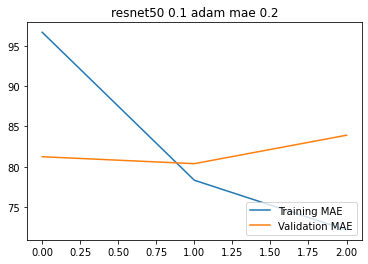

Epoch 1/3
87/87 [==============================] - ETA: 0s - loss: 104.4334 - mae: 104.4334
Epoch 1: val_mae improved from inf to 82.09678, saving model to ./resnet50 0.1 adam mae 0.3-best_weights_test.ckpt
87/87 [==============================] - 15s 129ms/step - loss: 104.4334 - mae: 104.4334 - val_loss: 82.0968 - val_mae: 82.0968
Epoch 2/3
87/87 [==============================] - ETA: 0s - loss: 77.6571 - mae: 77.6571
Epoch 2: val_mae improved from 82.09678 to 81.33434, saving model to ./resnet50 0.1 adam mae 0.3-best_weights_test.ckpt
87/87 [==============================] - 10s 114ms/step - loss: 77.6571 - mae: 77.6571 - val_loss: 81.3343 - val_mae: 81.3343
Epoch 3/3
87/87 [==============================] - ETA: 0s - loss: 73.1078 - mae: 73.1078
Epoch 3: val_mae improved from 81.33434 to 80.63924, saving model to ./resnet50 0.1 adam mae 0.3-best_weights_test.ckpt
87/87 [==============================] - 10s 113ms/step - loss: 73.1078 - mae: 73.1078 - val_loss: 80.6392 - val_mae: 8

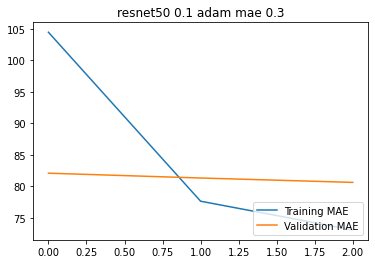

In [63]:
for params in hyper_params :
  key = ' '.join(map(str, params))
  model = bulid_model(params)
  history = fit_model(model=model,
                      epoch=3,
                      ckpt_path='./{}-best_weights_test.ckpt'.format(key))  #### 체크포인트 저장 경로
  if min(history.history['mae']) < history_dict['min_mae'] :
    history_dict['min_mae'] = min(history.history['mae'])
    history_dict['min_mae_param'] = key
  
  if min(history.history['val_mae']) < history_dict['min_val_mae'] :
    history_dict['min_val_mae'] = min(history.history['val_mae'])
    history_dict['min_val_mae_param'] = key

  draw_graph(key)

In [64]:
history_dict

{'min_mae': 72.16708374023438,
 'min_mae_param': 'resnet50 0.1 adam mae 0.2',
 'min_val_mae': 80.38420104980469,
 'min_val_mae_param': 'resnet50 0.1 adam mae 0.2'}